In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [14]:
first_row1=session.query(Measurement).first()
first_row1.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x18188f32460>,
 'prcp': 0.08,
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397',
 'date': '2010-01-01'}

In [15]:
first_row2=session.query(Station).first()
first_row2.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x18188f314c0>,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0}

# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
from sqlalchemy import desc



In [28]:
# Find the most recent date in the data set.
recent_date=session.query(Measurement.date).order_by(desc(Measurement.date)).first()
recent_date

('2017-08-23',)

In [200]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
my_date = dt.date(2017, 8, 23)-dt.timedelta(days=365)
my_date

datetime.date(2016, 8, 23)

In [203]:
# Perform a query to retrieve the data and precipitation scores

a=session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date>= my_date)
q=pd.DataFrame(a,columns=['Date','Precipitation'])

q.dropna(inplace=True)
# Save the query results as a Pandas DataFrame and set the index to the date column
mdf=q.set_index(['Date'])

mdf=mdf.sort_index()
mdf

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


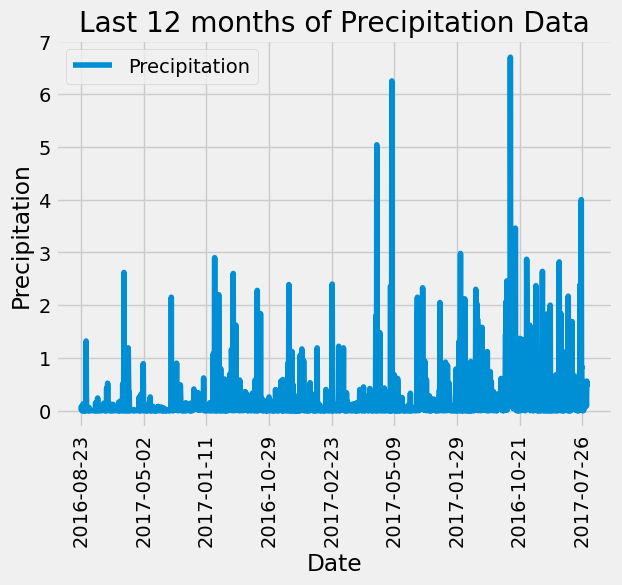

In [209]:

# Use Pandas Plotting with Matplotlib to plot the data
q.plot(x='Date',y='Precipitation',rot=90)
plt.title('Last 12 months of Precipitation Data')
plt.xlabel('Date')
plt.ylabel('Precipitation')

plt.show()

In [72]:
# Use Pandas to calcualte the summary statistics for the precipitation data
agg_list = {
    'prcp':
    ['mean', 'median', 'var', 'std', 'sem']
}
q.agg(agg_list)

,prcp
mean,0.176462
median,0.020000
var,0.211865
std,0.460288
sem,0.010254


# Exploratory Station Analysis

In [215]:
# Design a query to calculate the total number stations in the dataset
stationname =session.query(Measurement.station).distinct().all()
pd.DataFrame(stationname).count()

station    9
dtype: int64

In [216]:
#station names
stname=session.query(Measurement.station).group_by(Measurement.station).all()
stname

[('USC00511918',),
 ('USC00513117',),
 ('USC00514830',),
 ('USC00516128',),
 ('USC00517948',),
 ('USC00518838',),
 ('USC00519281',),
 ('USC00519397',),
 ('USC00519523',)]

In [217]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

sta=session.query(Measurement.station,func.count(Measurement.date)).group_by(Measurement.station).order_by(desc(func.count(Measurement.date))).all()
sta

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [218]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
ActiveStationCount=session.query(Measurement.station,func.count(Measurement.date)).group_by(Measurement.station).order_by(desc(func.count(Measurement.date))).first()
ActiveStationCount
ActiveStationID = list(ActiveStationCount)[0]
print("The most active station ID:", ActiveStationID)


The most active station ID: USC00519281


In [219]:
acthigh=session.query(Measurement.tobs).filter(Measurement.station==ActiveStationID).order_by(desc(Measurement.tobs)).first()
acthigh
print("Highest temperature for most active station ID:", acthigh)

Highest temperature for most active station ID: (85.0,)


In [220]:
actlow=session.query(Measurement.tobs).filter(Measurement.station==ActiveStationID).order_by((Measurement.tobs)).first()
actlow
print("Lowest temperature for most active station ID:", actlow)

Lowest temperature for most active station ID: (54.0,)


In [221]:
actaverage=session.query(Measurement.tobs,func.avg(Measurement.tobs)).filter(Measurement.station==ActiveStationID).scalar()
actaverage
print("Average temperature for most active station ID:", actaverage)

Average temperature for most active station ID: 70.0


In [222]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
act12=session.query(Measurement.tobs).\
filter(Measurement.date> my_date).filter(Measurement.station==ActiveStationID).all()
actdf=pd.DataFrame(data=act12)

actdf.dropna(inplace=True)
actdf

,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0
...,...
346,77.0
347,77.0
348,76.0
349,76.0


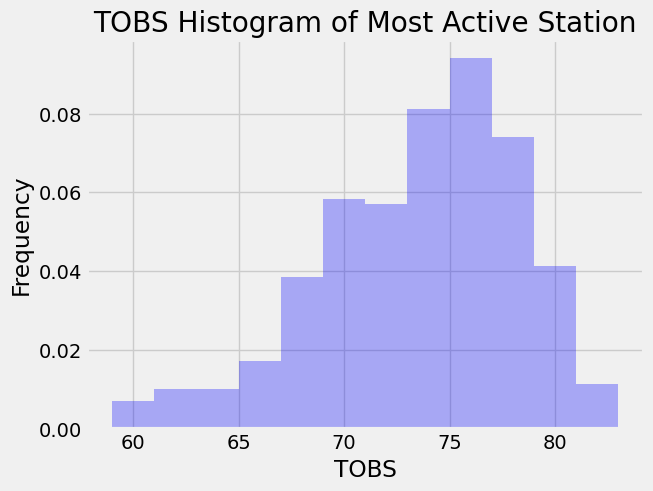

In [223]:
plt.hist(actdf, bins=12, density=True, alpha=0.3, color='blue')
plt.title('TOBS Histogram of Most Active Station')
plt.xlabel('TOBS')
plt.ylabel('Frequency')

plt.show()

# Close session

In [224]:
# Close Session
session.close()